In [1]:
# Install the needed libraries

!pip install catboost # python library to work with catboost methodology
!pip install shap
!pip install feature_engine
!pip install openpyxl # python library to read and write Excel 2010

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import standard libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

# Import libraries for data processing

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import OrdinalEncoder

# Import libraries for data modeling

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import catboost as cb

# Import feature importance library

import shap

In [3]:
# Predefine sns graph 

sns.set_style('whitegrid')
sns.set(font_scale=0.9)
sns.set(rc={'figure.figsize': (20,8)})
sns.color_palette("Greys")
plt.style.use("fivethirtyeight")

In [4]:
# Upload xlsx file to data frame

df = pd.read_excel('E Commerce Dataset.xlsx', 'E Comm')
data = df
df.sample(5)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
5436,55437,0,11.0,Mobile Phone,3,16.0,E wallet,Male,3.0,5,Laptop & Accessory,4,Married,3,0,15.0,2.0,2.0,4.0,166.89
926,50927,0,17.0,Computer,3,6.0,E wallet,Female,3.0,3,Laptop & Accessory,3,Divorced,8,0,12.0,1.0,1.0,0.0,147.68
780,50781,0,2.0,Mobile Phone,1,6.0,Debit Card,Female,2.0,4,Grocery,2,Married,4,0,14.0,NaN,1.0,7.0,261.24
2928,52929,0,6.0,Mobile Phone,3,11.0,Debit Card,Female,3.0,4,Mobile Phone,4,Divorced,4,0,12.0,2.0,2.0,3.0,164.31
4350,54351,0,26.0,Mobile Phone,1,7.0,Debit Card,Male,4.0,5,Others,3,Married,2,0,15.0,8.0,12.0,10.0,324.99


In [ ]:
# split metrics to categorical and numerical / interval, ordinal, nominal,... / and do not use primary key CustomerID in feature engineering

In [5]:
# split variables to 4 categorical and 13 numerical

cats = ['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus']
nums = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress',
        'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'CityTier', 'SatisfactionScore','Complain']

# create the list of 10 continuous/float numerical variables ('CityTier', 'SatisfactionScore','Complain' are not interval/float)

cont_interval  = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress',
                     'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# split categorical variables to 5 ordinal and 4 nominal

cats_ordinal = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
cats_nominal = ['Churn', 'CityTier', 'SatisfactionScore','Complain']



In [6]:
# Information about dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [17]:
# Find missing values

df.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [18]:
# Revise summary statistics for all integers and floats before missing values inputation - numerical data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,52815.500000,1625.385339,50001.0,51408.25,52815.50,54222.7500,55630.00
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.0000,1.00
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00


In [19]:
# Revise summary statistics - for all object/catagorical data

df[cats_ordinal].describe()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [20]:
# pivot counts for all categorical ordinal variables 

for col in cats_ordinal:
  print(f'''Value count Colums {col}:''')
  print(df[col].value_counts())
  print()

Value count Colums PreferredLoginDevice:
Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64

Value count Colums PreferredPaymentMode:
Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64

Value count Colums Gender:
Male      3384
Female    2246
Name: Gender, dtype: int64

Value count Colums PreferedOrderCat:
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Value count Colums MaritalStatus:
Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64



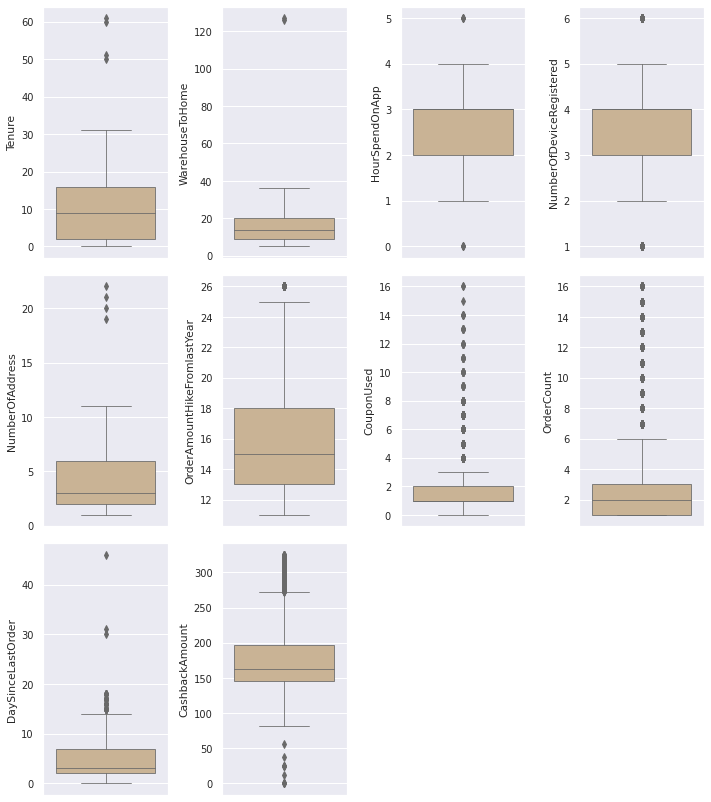

In [21]:
# create box plots for all continuous numerical variables / floats

features = cont_interval
plt.figure(figsize=(10,15))

# decrease font size of all elements

sns.set(font_scale=0.9)
for i in range(0, len(features)):
  plt.subplot(4, 4, i+1)
  sns.boxplot(y=df[features[i]], color='tan', orient='v', width=0.8,linewidth=0.8)
  plt.tight_layout()

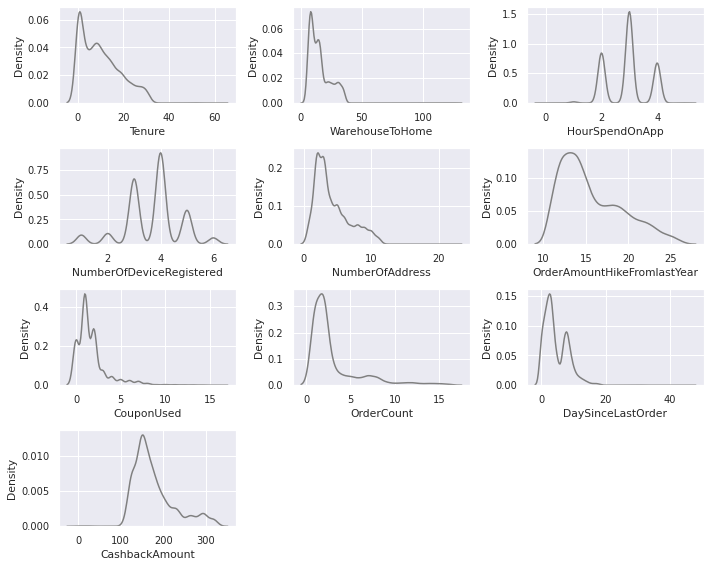

In [22]:
# create histograms for all continuous variables / floats

features = cont_interval
plt.figure(figsize=(10,8))
for i in range(0, len(features)):
  plt.subplot(4, 3, i+1)
  sns.kdeplot(x=df[features[i]], color='grey')
  plt.xlabel(features[i])
  plt.tight_layout()

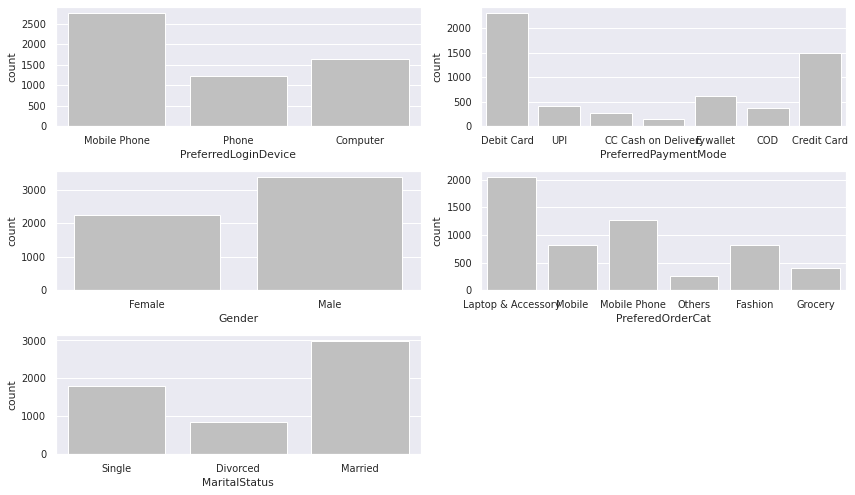

In [13]:
# plot customer ID count for each ordinal category / object

features = cats_ordinal
plt.figure(figsize=(12, 7))
for i in range(0, len(features)):
  plt.subplot(3, 2, i+1)
  sns.countplot(x=df[features[i]], color = 'silver')
  plt.tight_layout()

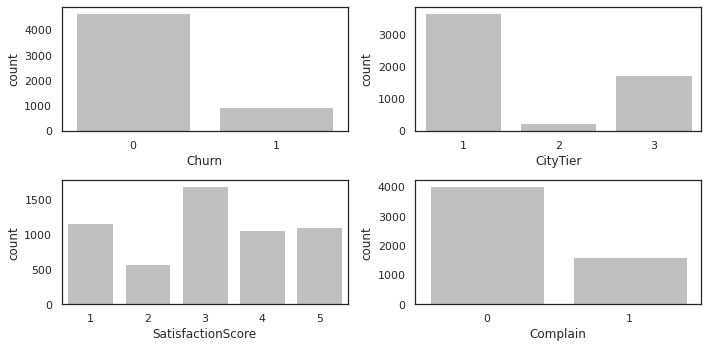

In [23]:
# plot customer ID count for each nominal category / integer

sns.set(style='white')
features = cats_nominal
plt.figure(figsize=(10, 5))
for i in range(0, len(features)):
  plt.subplot(2, 2, i+1)
  sns.countplot(x=df[features[i]], color = 'silver')
  plt.tight_layout()

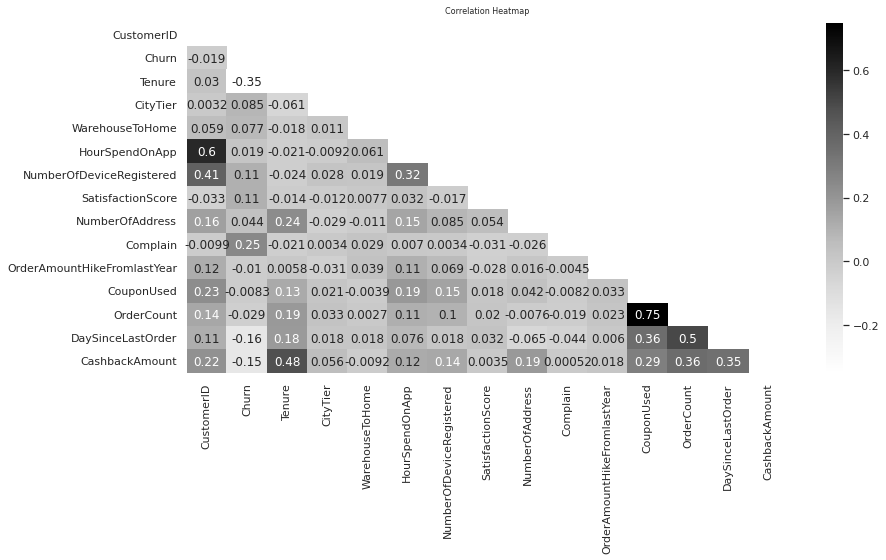

In [15]:
# Correlation Analysis for all numerical variables - integers and floats

plt.figure(figsize=(12, 6))

# Create mask for diagonal correlation plot

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

# Plot the heatmap

heatmap = sns.heatmap(df.corr(), mask=mask, annot=True, cmap='Greys' )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=10);

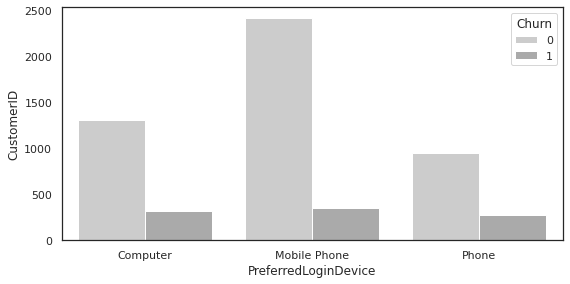

In [16]:
# plot number of unique customer IDs by Churn flag and by Device

plt.figure(figsize=(8, 4))
colors = ["#CCCCCC", "#AAAAAA"]

# Set your custom color palette

palette= sns.set_palette(sns.color_palette(colors))
df9=df.groupby(['PreferredLoginDevice','Churn']).agg({'CustomerID':'nunique'}).reset_index()
sns.barplot(x='PreferredLoginDevice', y ='CustomerID', hue='Churn', data=df9, palette=palette );

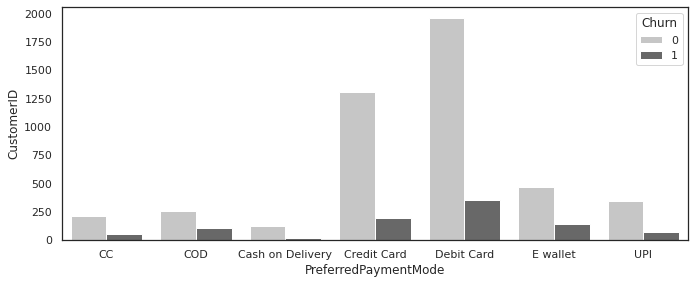

In [ ]:
# plot number of unique cutomer IDs by Churn flag and by Payment method

sns.set(style='white')
plt.figure(figsize=(10, 4))
df10=df.groupby(['PreferredPaymentMode','Churn']).agg({'CustomerID':'nunique'}).reset_index()
sns.barplot(x='PreferredPaymentMode', y ='CustomerID', hue='Churn', data=df10, palette='Greys');

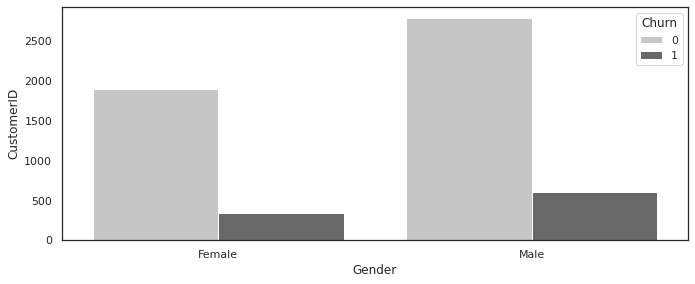

In [ ]:
# plot number of unique customer IDs by Churn flag and by Gender

sns.set(style='white')
plt.figure(figsize=(10, 4))
df11=df.groupby(['Gender','Churn']).agg({'CustomerID':'nunique'}).reset_index()
sns.barplot(x='Gender', y ='CustomerID', hue='Churn', data=df11, palette='Greys' );


In [ ]:
# pivot unique customer IDs by churn and hours spent

df11_test = df.groupby(['HourSpendOnApp','Churn']).agg({'CustomerID':'nunique'}).reset_index()
df11_test

,HourSpendOnApp,Churn,CustomerID
0,0.0,0,3
1,1.0,0,35
2,2.0,0,1239
3,2.0,1,232
4,3.0,0,2227
5,3.0,1,460
6,4.0,0,978
7,4.0,1,198
8,5.0,0,3


<Figure size 720x288 with 0 Axes>

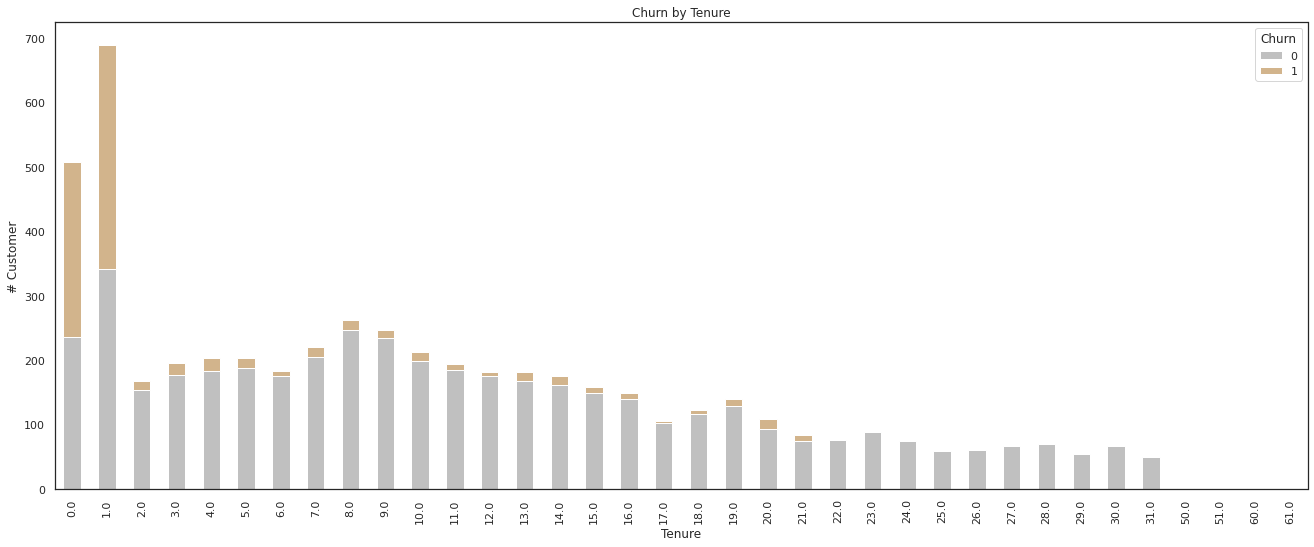

In [24]:
# plot count of Customer IDs by Churn flag and by Tenure (number of months the customer is with company)
# the most of the customers leave in the 1st or 2nd month 
sns.set(style='white')
plt.figure(figsize=(10, 4))
int_churn_contingency = pd.crosstab(data["Tenure"], data["Churn"])
int_churn_contingency.plot(kind = 'bar', stacked = 'true',  color=['silver', 'tan'], title = "Churn by Tenure")
int_churn_contingency
plt.xlabel('Tenure')
plt.ylabel('# Customer')
plt.show()

In [ ]:
# split the dataset to test 20 % and train 80 %, use the obvious random state 42 for chain
# target variable y is Churn and all variables apart of Customer ID are considered

x = df.drop(columns=['CustomerID','Churn'])
y = df['Churn']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# all integer categories are encoded, for gender we use ordinal encoder and for other integers we use one hot encoder
# ordinal encoding, one hot encoding and dummy variable encoding are the most often encoding methodologies

In [ ]:
# encode lables by 1. ordinal encoder, Ordinal encoder is considering only 1 variable, Gender
# let the encoder find the unique values per 1 feature, result is transformed /trained/ data

def label_encoding(x_train, x_test):
  ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables='Gender')
  ordinal_encoder.fit(x_train)
  x_train = ordinal_encoder.transform(x_train)
  x_test = ordinal_encoder.transform(x_test)
  return x_train, x_test

In [ ]:
x_train, x_test = label_encoding(x_train,x_test)

In [ ]:
# encode lables by 2. one hot encoder, one hot encoder is considering 4 variables
# let the encoder find the unique values per 4 features, result is transformed /trained/ data

def label_ohe(x_train, x_test):
  cat_features = ['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus']
  ohe_encoder = OneHotEncoder(variables=cat_features)
  ohe_encoder.fit(x_train)
  x_train = ohe_encoder.transform(x_train)
  x_test = ohe_encoder.transform(x_test)

  return x_train, x_test

In [ ]:
x_train , x_test=label_ohe(x_train, x_test)

In [ ]:
# Final result of label endcoding for integer categories

x_train

,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_CC,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
4478,1.0,1,12.0,0,3.0,4,4,3,1,13.0,...,0,1,0,0,0,0,0,1,0,0
3685,17.0,1,13.0,0,4.0,5,3,3,1,15.0,...,0,0,1,0,0,0,0,1,0,0
731,0.0,1,9.0,1,NaN,4,3,2,0,12.0,...,0,0,0,1,0,0,0,1,0,0
291,NaN,1,8.0,1,2.0,3,2,2,1,23.0,...,0,1,0,0,0,0,0,0,1,0
184,4.0,1,11.0,1,2.0,3,2,1,1,12.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.0,1,27.0,1,4.0,4,3,2,0,15.0,...,0,0,1,0,0,0,0,1,0,0
5191,10.0,3,16.0,1,3.0,4,1,6,0,12.0,...,0,0,0,0,1,0,0,0,0,1
5226,7.0,1,11.0,0,3.0,5,4,10,0,12.0,...,0,1,0,0,0,0,0,0,0,1
5390,1.0,1,36.0,1,4.0,4,5,3,0,14.0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4504 entries, 4478 to 860
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Tenure                                 4288 non-null   float64
 1   CityTier                               4504 non-null   int64  
 2   WarehouseToHome                        4301 non-null   float64
 3   Gender                                 4504 non-null   int64  
 4   HourSpendOnApp                         4298 non-null   float64
 5   NumberOfDeviceRegistered               4504 non-null   int64  
 6   SatisfactionScore                      4504 non-null   int64  
 7   NumberOfAddress                        4504 non-null   int64  
 8   Complain                               4504 non-null   int64  
 9   OrderAmountHikeFromlastYear            4288 non-null   float64
 10  CouponUsed                             4301 non-null   float64
 11  Or

In [ ]:
# prepare variables, which have missing values

cat_features = ['Tenure','WarehouseToHome','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']
cont_features = ['HourSpendOnApp']

In [ ]:
# replace missing values by median or most frequent (do not use mean because of outliers are present)

def imputation (x_train, 
                x_test,
                cont_features,
                cat_features,
                cont_strategy = 'median',
                cat_strategy = 'most_frequent'
                ):

# initialize object imputer

  imputerCat = SimpleImputer(missing_values=np.nan, strategy= cat_strategy)
  imputerCont = SimpleImputer(missing_values=np.nan, strategy= cont_strategy)

# fit to data train

  imputerCont.fit(x_train[cont_features])
  imputerCat.fit(x_train[cat_features])

# transfrom to data train

  x_train[cont_features] = imputerCont.transform(x_train[cont_features])
  x_train[cat_features] = imputerCat.transform(x_train[cat_features])
  x_test[cont_features] = imputerCont.transform(x_test[cont_features])
  x_test[cat_features] = imputerCat.transform(x_test[cat_features])

  return x_train, x_test

In [ ]:
# initialize object imputer

x_train , x_test = imputation(x_train, x_test,cont_features, cat_features)

In [ ]:
# see data after integer encoding and imputation

x_train

,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_CC,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
4478,1.0,1,12.0,0,3.0,4,4,3,1,13.0,...,0,1,0,0,0,0,0,1,0,0
3685,17.0,1,13.0,0,4.0,5,3,3,1,15.0,...,0,0,1,0,0,0,0,1,0,0
731,0.0,1,9.0,1,3.0,4,3,2,0,12.0,...,0,0,0,1,0,0,0,1,0,0
291,1.0,1,8.0,1,2.0,3,2,2,1,23.0,...,0,1,0,0,0,0,0,0,1,0
184,4.0,1,11.0,1,2.0,3,2,1,1,12.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.0,1,27.0,1,4.0,4,3,2,0,15.0,...,0,0,1,0,0,0,0,1,0,0
5191,10.0,3,16.0,1,3.0,4,1,6,0,12.0,...,0,0,0,0,1,0,0,0,0,1
5226,7.0,1,11.0,0,3.0,5,4,10,0,12.0,...,0,1,0,0,0,0,0,0,0,1
5390,1.0,1,36.0,1,4.0,4,5,3,0,14.0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
# A - Functional Train versus Test modeling
# import libraries to calculate various scores for models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def get_metrics(y_pred, y_act, model_name):
  recall =  recall_score(y_act, y_pred)
  precision = precision_score(y_act, y_pred)
  roc_auc = roc_auc_score(y_act, y_pred)
  f1 = f1_score(y_act, y_pred)
  accuracy = balanced_accuracy_score(y_act, y_pred)

# define the output 
  metrics_result = dict(model_name=model_name, 
                        recall=recall, 
                        precision=precision, 
                        roc_auc=roc_auc, 
                        f1=f1,
                        accuracy=accuracy)
  
  return metrics_result

# clf stands for classifier, it is estimator instance to store the trained model, so that we can use it further
# this notebook is comparing scores for classifiers: XGBClassifier, CatBoostClassifier, LogisticRegression, RandomForestClassifier, KNeighborsClassifier, AdaBoostClassifier

def prediction(x_train, y_train, x_test, y_test, clf, model_name='decision tree'):
  
  clf = clf
  clf.fit(x_train, y_train)
  y_test_pred = clf.predict(x_test)
  y_train_pred = clf.predict(x_train)


  result = dict()
  test_result = get_metrics(y_pred=y_test_pred, y_act=y_test, model_name=model_name)
  train_result = get_metrics(y_pred=y_train_pred, y_act=y_train, model_name=model_name)

  result['test'] = test_result
  result['train'] = train_result
  result['y_test'] = y_test
  result['y_test_pred'] = y_test_pred
  result['y_train'] = y_train
  result['y_train_pred'] = y_train_pred
  result['clf'] = clf
  result['x_train'] = x_train
  result['x_test'] = x_test



  del clf

  return result
  
def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

# plot results to horizontal bar chart
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [ ]:
model_1_result = prediction(x_train, y_train, x_test, y_test, tree.DecisionTreeClassifier(), model_name='decision tree')
model_2_result = prediction(x_train, y_train, x_test, y_test, xgb.XGBClassifier(random_state=42), model_name='xgboost')
model_3_result = prediction(x_train, y_train, x_test, y_test, cb.CatBoostClassifier(random_state=42, logging_level='Silent'), model_name='catboost')
model_4_result = prediction(x_train, y_train, x_test, y_test, LogisticRegression(), model_name='logistic regression')
model_5_result = prediction(x_train, y_train, x_test, y_test, RandomForestClassifier(random_state=42), model_name='random forest')
model_6_result = prediction(x_train, y_train, x_test, y_test, KNeighborsClassifier(), model_name='kNN')
model_7_result = prediction(x_train, y_train, x_test, y_test, AdaBoostClassifier(random_state=42), model_name='adaboost')

In [ ]:
#  print scores for each classification method

#  perfect recall score of 1.0 means that all relevant documents were retrieved by the search (but says nothing about how many irrelevant documents were also retrieved).
#  perfect precision score of 1.0 means that every result retrieved by a search was relevant (but says nothing about whether all relevant documents were retrieved). 
#  AUC above 0.85 means high classification accuracy, one between 0.75 and 0.85 moderate accuracy, and one less than 0.75 low accuracy (D' Agostino, Rodgers, & Mauck, 2018).
#  perfect model has f1 score equal to 1.0, if recall or precision are 0, than f1 is the worst case of 0.
#  balanced accuracy score, (TP plus TN)/2, over 0.9 is very good, between 0.7 and 0.9 is good. 

pd.DataFrame([model_1_result['train'], 
              model_2_result['train'], 
              model_3_result['train'], 
              model_4_result['train'], 
              model_5_result['train'],
              model_6_result['train'], 
              model_7_result['train']])

,model_name,recall,precision,roc_auc,f1,accuracy
0,decision tree,1.000000,1.000000,1.000000,1.000000,1.000000
1,xgboost,0.665793,0.886562,0.824209,0.760479,0.824209
2,catboost,0.959371,0.997275,0.979418,0.977956,0.979418
3,logistic regression,0.519004,0.722628,0.739187,0.604119,0.739187
4,random forest,1.000000,1.000000,1.000000,1.000000,1.000000
5,kNN,0.557012,0.792910,0.763670,0.654349,0.763670
6,adaboost,0.589777,0.756303,0.775509,0.662739,0.775509


In [ ]:
# tree models performed better than the linear models
# tree models overtitted, their training f1-score is higher than their testing f1-score

In [ ]:
pd.DataFrame([model_1_result['test'], 
              model_2_result['test'], 
              model_3_result['test'], 
              model_4_result['test'], 
              model_5_result['test'],
              model_6_result['test'], 
              model_7_result['test']])

,model_name,recall,precision,roc_auc,f1,accuracy
0,decision tree,0.902703,0.938202,0.945507,0.920110,0.945507
1,xgboost,0.627027,0.852941,0.802887,0.722741,0.802887
2,catboost,0.816216,0.974194,0.905983,0.888235,0.905983
3,logistic regression,0.551351,0.796875,0.761861,0.651757,0.761861
4,random forest,0.827027,1.000000,0.913514,0.905325,0.913514
5,kNN,0.400000,0.627119,0.676621,0.488449,0.676621
6,adaboost,0.616216,0.808511,0.793762,0.699387,0.793762


In [ ]:
print(classification_report(model_1_result['y_test'], model_5_result['y_test_pred']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       941
           1       1.00      0.83      0.91       185

    accuracy                           0.97      1126
   macro avg       0.98      0.91      0.94      1126
weighted avg       0.97      0.97      0.97      1126



In [ ]:
#  tune the hyperparameters to reduce overfitting and improve test performance
#  use the scikit-optimize libraries for tuning the hyperparameters: e.g. BayesSearchCV, RandomizedSearchCV, GridSearchCV,...

#  B - DETAILED MODELING - get more details for each classification method and test more parameters for final decision

In [ ]:
#  model 4. - logistic regression
#  choose the best regularisation and best penalty

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)
print('Train score: ' + str(model.score(x_train, y_train))) #accuracy
print('Test score:' + str(model.score(x_test, y_test))) #accuracy

Train score: 0.8847690941385435
Test score:0.9031971580817052


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters 

penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Choose model

logres = LogisticRegression(random_state=42) # Init Logres Gridsearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation

logres_hyper = prediction(x_train, y_train, x_test, y_test, model, model_name='logistic regression_hyperparam')

In [ ]:
print('Best algorithm:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best algorithm: l2
Best C: 0.002


In [ ]:
print('Train score: ' + str(model.score(x_train, y_train))) #recall
print('Test score: ' + str(model.score(x_test, y_test))) #recall

Train score: 0.2699868938401048
Test score: 0.24864864864864866


In [ ]:
#  model 6. - KNN
#  choose the nearest neighbors, best penalty and best algorithm

In [ ]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)
print('Train score: ' + str(model.score(x_train, y_train))) #recall
print('Test score:' + str(model.score(x_test, y_test))) #recall

Train score: 0.9003108348134992
Test score:0.8623445825932504


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameters

n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Choose model

knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fit Model

kkn_hyper = prediction(x_train, y_train, x_test, y_test, model, model_name='kNN_hyperparam')

In [ ]:
print('Best n_neighbors:', model.best_estimator_.get_params()['n_neighbors'])
print('Best p:', model.best_estimator_.get_params()['p'])
print('Best algorithm:', model.best_estimator_.get_params()['algorithm'])

Best n_neighbors: 5
Best p: 1
Best algorithm: ball_tree


In [ ]:
print('Train score: ' + str(model.score(x_train, y_train))) #recall
print('Test score: ' + str(model.score(x_test, y_test))) #recall

Train score: 0.5871559633027523
Test score: 0.4486486486486487


In [ ]:
#  model 1. - Decidion Tree
#  choose the max depth, min samples split, min samples leaf and max features

In [ ]:
model = tree.DecisionTreeClassifier() 
model.fit(x_train,y_train)
print('Train score: ' + str(model.score(x_train, y_train))) #recall
print('Test score:' + str(model.score(x_test, y_test))) #recall

Train score: 1.0
Test score:0.9626998223801065


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameters

max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Choose Model

dt = tree.DecisionTreeClassifier()
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')
model.fit(x_train, y_train)

# Predict

dt_hyper = prediction(x_train, y_train, x_test, y_test, model, model_name='decision tree_hyperparam')
dt_hyper

{'test': {'model_name': 'decision tree_hyperparam',
  'recall': 0.6,
  'precision': 0.7928571428571428,
  'roc_auc': 0.7845908607863975,
  'f1': 0.683076923076923,
  'accuracy': 0.7845908607863974},
 'train': {'model_name': 'decision tree_hyperparam',
  'recall': 0.7549148099606815,
  'precision': 0.891640866873065,
  'roc_auc': 0.868101617757673,
  'f1': 0.8176011355571327,
  'accuracy': 0.868101617757673},
 'y_test': 4331    1
 1988    0
 3443    0
 4559    0
 4898    0
        ..
 3740    0
 833     0
 4441    0
 4490    0
 2842    0
 Name: Churn, Length: 1126, dtype: int64,
 'y_test_pred': array([0, 0, 0, ..., 0, 0, 0]),
 'y_train': 4478    0
 3685    0
 731     0
 291     0
 184     0
        ..
 3772    0
 5191    1
 5226    0
 5390    0
 860     1
 Name: Churn, Length: 4504, dtype: int64,
 'y_train_pred': array([0, 0, 0, ..., 0, 0, 1]),
 'clf': RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                    param_distributions={'max_depth': [1, 4, 8, 12, 16, 19,

In [ ]:
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])

Best max_depth: 87
Best min_samples_split: 10
Best min_samples_leaf: 1
Best max_features: sqrt


In [ ]:
print('Train score: ' + str(model.score(x_train, y_train))) # recall
print('Test score: ' + str(model.score(x_test, y_test))) # recall

Train score: 0.7549148099606815
Test score: 0.6


In [ ]:
#  model 5. - Random Forest
#  choose the random state, estimators, bootstrap,criterion, max depth, min samples split, min samples leaf, max features, n jobs, ...

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train,y_train)
print('Train score: ' + str(rf.score(x_train, y_train))) # recall
print('Test score: ' + str(rf.score(x_test, y_test))) # recall

Train score: 1.0
Test score: 0.9715808170515098


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters 

hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # 
                       bootstrap = [True], # sample with replacement
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # minimum samples 
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # minimum samples 
                       max_features = ['auto', 'sqrt', 'log2'], # split
                       n_jobs = [-1], # Core parallel computation. -1 
                      )

# Choose Model

rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')

# Predict

rf_hyper = prediction(x_train, y_train, x_test, y_test, rf_tuned, model_name='random forest_hyperparam')
rf_hyper

{'test': {'model_name': 'random forest_hyperparam',
  'recall': 0.7945945945945946,
  'precision': 1.0,
  'roc_auc': 0.8972972972972972,
  'f1': 0.8855421686746988,
  'accuracy': 0.8972972972972972},
 'train': {'model_name': 'random forest_hyperparam',
  'recall': 0.9960681520314548,
  'precision': 1.0,
  'roc_auc': 0.9980340760157274,
  'f1': 0.9980302035456337,
  'accuracy': 0.9980340760157274},
 'y_test': 4331    1
 1988    0
 3443    0
 4559    0
 4898    0
        ..
 3740    0
 833     0
 4441    0
 4490    0
 2842    0
 Name: Churn, Length: 1126, dtype: int64,
 'y_test_pred': array([1, 0, 0, ..., 0, 0, 0]),
 'y_train': 4478    0
 3685    0
 731     0
 291     0
 184     0
        ..
 3772    0
 5191    1
 5226    0
 5390    0
 860     1
 Name: Churn, Length: 4504, dtype: int64,
 'y_train_pred': array([0, 0, 0, ..., 0, 0, 1]),
 'clf': RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                    param_distributions={'bootstrap': [True],
         

In [ ]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 400
Best bootstrap: True
Best criterion: gini
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1
Best max_features: log2
Best n_jobs: -1


In [ ]:
print('Train score: ' + str(rf_tuned.score(x_train, y_train))) #recall
print('Test score: ' + str(rf_tuned.score(x_test, y_test))) #recall

Train score: 0.9960681520314548
Test score: 0.7945945945945946


In [ ]:
#  model 7. - AdaBoost
#  choose the estimators, learning rate and algorithm 

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(x_train,y_train)
print('Train score: ' + str(ab.score(x_train, y_train))) #recall
print('Test score: ' + str(ab.score(x_test, y_test))) #recall

Train score: 0.8983126110124334
Test score: 0.9129662522202486


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameters

hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # 
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Choose model

ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall')

# Predict

ad_hyper = prediction(x_train, y_train, x_test, y_test, ab_tuned, model_name='adaboost_hyperparam')

In [ ]:
show_best_hyperparameter(ab_tuned.best_estimator_, hyperparameters)

Best n_estimators: 1700
Best learning_rate: 0.07394736842105264
Best algorithm: SAMME.R


In [ ]:
print('Train score: ' + str(ab_tuned.score(x_train, y_train))) #recall
print('Test score: ' + str(ab_tuned.score(x_test, y_test))) #recall

Train score: 0.5950196592398427
Test score: 0.6216216216216216


In [ ]:
#  model 3. - CatBoost
#  choose the random state, logging level, estimators, learning rate

In [ ]:
cat = cb.CatBoostClassifier(random_state=42, logging_level='Silent')
cat.fit(x_train,y_train)
print('Train score: ' + str(cat.score(x_train, y_train))) #recall
print('Test score: ' + str(cat.score(x_test, y_test))) #recall

Train score: 0.9926731793960923
Test score: 0.9662522202486679


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameters

hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)]
                      )

# Choose model

cat = cb.CatBoostClassifier(random_state=42,logging_level='Silent')
cat_tuned = RandomizedSearchCV(cat, hyperparameters, random_state=42, cv=5, scoring='recall')

# Predict

cat_hyper = prediction(x_train, y_train, x_test, y_test, cat_tuned, model_name='cat boost_hyperparam')

In [ ]:
show_best_hyperparameter(cat_tuned.best_estimator_, hyperparameters)

Best n_estimators: 1000
Best learning_rate: 0.08436842105263158


In [ ]:
print('Train score: ' + str(cat_tuned.score(x_train, y_train))) #recall
print('Test score: ' + str(cat_tuned.score(x_test, y_test))) #recall

Train score: 1.0
Test score: 0.9351351351351351


In [ ]:
#  model 2. - XGB
#  choose the random state, max depth, min weigth, gamma, best tree method, ...

In [ ]:
xg = xgb.XGBClassifier(random_state=42)
xg.fit(x_train, y_train)
print('Train score: ' + str(xg.score(x_train, y_train))) #recall
print('Test score: ' + str(xg.score(x_test, y_test))) #recall

Train score: 0.9289520426287744
Test score: 0.9209591474245116


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameters

hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Choose model

xg = xgb.XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')

# Predict

xg_hyper = prediction(x_train, y_train, x_test, y_test, xg_tuned, model_name='xgboost_hyperparam')

In [ ]:
show_best_hyperparameter(xg_tuned.best_estimator_, hyperparameters)

Best max_depth: 110
Best min_child_weight: 2
Best gamma: 0.5
Best tree_method: hist
Best colsample_bytree: 1.0
Best eta: 0.7777777777777778
Best lambda: 0.2
Best alpha: 0.1


In [ ]:
print('Train score: ' + str(xg_tuned.score(x_train, y_train))) #recall
print('Test score: ' + str(xg_tuned.score(x_test, y_test))) #recall

Train score: 0.9986893840104849
Test score: 0.8972972972972973


In [ ]:
# compare scores for each model for train

In [ ]:
pd.DataFrame([logres_hyper['train'], 
              kkn_hyper['train'], 
              dt_hyper['train'], 
              rf_hyper['train'], 
              ad_hyper['train'],
              cat_hyper['train'],
              xg_hyper['train']
              ])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression_hyperparam,0.269987,0.792308,0.627776,0.402737,0.627776
1,kNN_hyperparam,0.587156,0.825046,0.780881,0.686064,0.780881
2,decision tree_hyperparam,0.754915,0.891641,0.868102,0.817601,0.868102
3,random forest_hyperparam,0.996068,1.000000,0.998034,0.998030,0.998034
4,adaboost_hyperparam,0.595020,0.769492,0.779333,0.671101,0.779333
5,cat boost_hyperparam,1.000000,1.000000,1.000000,1.000000,1.000000
6,xgboost_hyperparam,0.998689,1.000000,0.999345,0.999344,0.999345


In [ ]:
# compare scores for each model for test

In [ ]:
pd.DataFrame([logres_hyper['test'], 
              kkn_hyper['test'], 
              dt_hyper['test'], 
              rf_hyper['test'], 
              ad_hyper['test'],
              cat_hyper['test'],
              xg_hyper['test']
              ])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression_hyperparam,0.248649,0.836364,0.619542,0.383333,0.619542
1,kNN_hyperparam,0.448649,0.697479,0.705196,0.546053,0.705196
2,decision tree_hyperparam,0.600000,0.792857,0.784591,0.683077,0.784591
3,random forest_hyperparam,0.794595,1.000000,0.897297,0.885542,0.897297
4,adaboost_hyperparam,0.621622,0.827338,0.798058,0.709877,0.798058
5,cat boost_hyperparam,0.935135,0.994253,0.967036,0.963788,0.967036
6,xgboost_hyperparam,0.897297,0.988095,0.947586,0.940510,0.947586


In [ ]:
# After building the 7 models, the tree classifiers performed better than the linear classifiers, with XGBoost and CatBoost performing the best. 
# After hyperparameters tunning for Xgboost and CatBoost we can further improve score.

In [ ]:
# Catboost is performing the best, use it to calculate y churn prediction
y_pred = cat_tuned.predict(x_test)
y_pred_train = cat_tuned.predict(x_train)

In [ ]:
# load JS visualization code to notebook
shap.initjs()


In [ ]:
# Prepare shap model for interpretation of CatBoost, use shap model for easy feature sorting

explainer = shap.Explainer(cat_hyper['clf'].predict, cat_hyper['x_test'])
shap_values_cat = explainer(cat_hyper['x_test'])

Permutation explainer: 1127it [01:57,  8.90it/s]                          


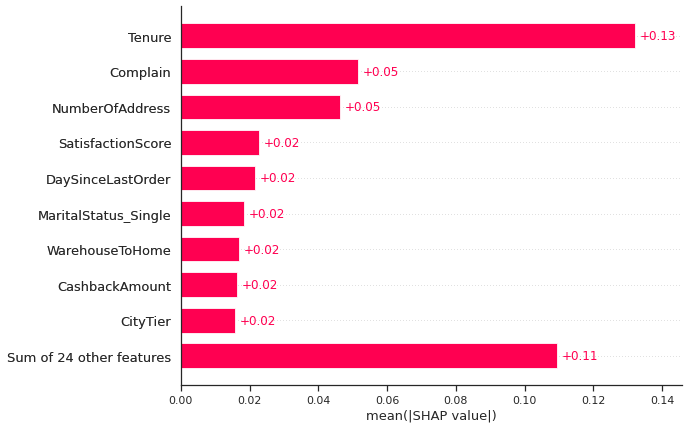

In [ ]:
# This graph is too pink
shap.plots.bar(shap_values_cat)

In [ ]:
feature_names = shap_values_cat.feature_names

In [ ]:
shap_df = pd.DataFrame(shap_values_cat.values, columns=feature_names)

In [ ]:
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.rename(columns = {'col_name':'Feature', 'feature_importance_vals':'Importance score'}, inplace = True)
shap_importance.sort_values(by=['Importance score'], ascending=False, inplace=True)

In [ ]:
shap_importance

,Feature,Importance score
0,Tenure,0.132182
8,Complain,0.051488
7,NumberOfAddress,0.046210
6,SatisfactionScore,0.022714
12,DaySinceLastOrder,0.021555
30,MaritalStatus_Single,0.018425
2,WarehouseToHome,0.016945
13,CashbackAmount,0.016218
1,CityTier,0.015785
9,OrderAmountHikeFromlastYear,0.014827


In [ ]:
top10=shap_importance.head(10)

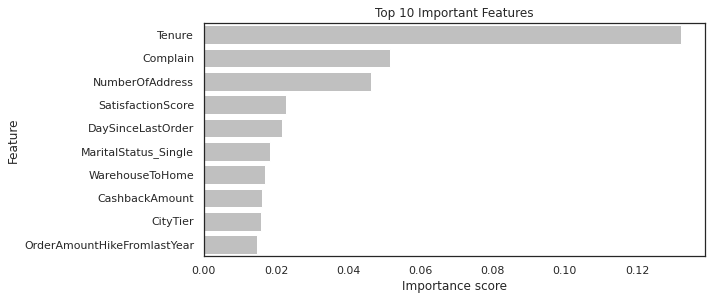

In [ ]:
# plot top 10 features
plt.figure(figsize=(8, 4))
plt.title('Top 10 Important Features')
sns.barplot(y='Feature', x ='Importance score', color='silver', data=top10);

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[940   1]
 [ 12 173]]


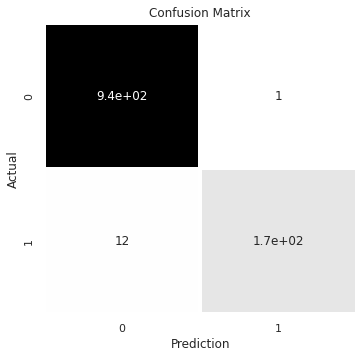

In [ ]:
# Specify the heatmap size
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=3,cbar=False, cmap="Greys")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [ ]:
# Confusion Matrix Train
cf_matrix1 = confusion_matrix(y_train, y_pred_train)

print(cf_matrix1)

[[3741    0]
 [   0  763]]


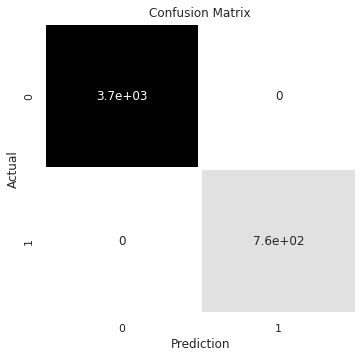

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_train,y_pred_train),annot=True,linewidths=3,cbar=False, cmap="Greys")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

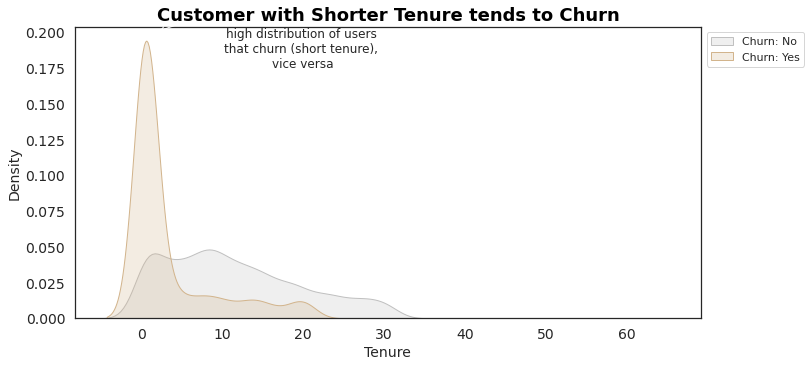

In [ ]:
# Plot Churn flag by Tenure 
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style='white')
sns.kdeplot(df[df['Churn'] == 0]['Tenure'].dropna(), color= 'silver', label= 'Churn: No', ax=ax, fill=True)
sns.kdeplot(df[df['Churn'] == 1]['Tenure'].dropna(), color= 'tan', label= 'Churn: Yes', ax=ax, fill=True)

ax.set_title('Customer with Shorter Tenure tends to Churn',color='black',fontsize=18,fontweight='bold')
ax.set_ylabel('Density', fontsize=14) # y axis label
ax.set_xlabel('Tenure', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(loc='upper left',bbox_to_anchor=(1,1),ncol=1)


ax.annotate('high distribution of users \nthat churn (short tenure), \nvice versa', 
            xy=(2, 0.2), xytext=(20, 0.175), arrowprops=dict(facecolor='grey',arrowstyle="->",connectionstyle="arc3,rad=.3"),
           ha='center');

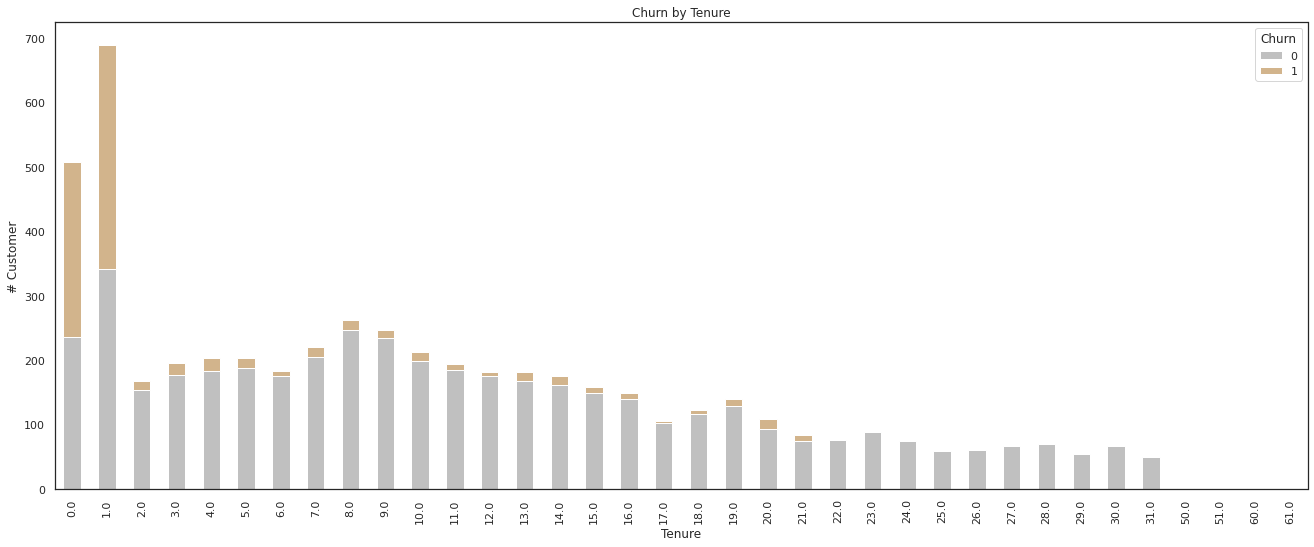

In [ ]:
# Plot Customer count by Churn flag and by Tenure 
int_churn_contingency = pd.crosstab(data["Tenure"], data["Churn"])
int_churn_contingency.plot(kind = 'bar', stacked = 'true', title = "Churn by Tenure",color=['silver', 'tan'], fill=True)
int_churn_contingency
plt.xlabel('Tenure')
plt.ylabel('# Customer')
plt.show()

In [ ]:
group_by_complain = df.groupby(['PreferedOrderCat','Complain']).agg({'CustomerID':'nunique'}).reset_index()
group_by_complain['Complain'] = group_by_complain['Complain'].replace({1:'Complain',
                                                                0:'Not Complain'})

group_by_complain2 = df.groupby(['PreferedOrderCat']).agg({'CustomerID':'nunique'}).reset_index()
group_by_complain3 = group_by_complain.merge(group_by_complain2, how='left',
              on='PreferedOrderCat')

group_by_complain3.columns = ['PreferedOrderCat','Complain','Num_Customer','AllCustomer']
group_by_complain3['Ratio'] = (group_by_complain3['Num_Customer'] / group_by_complain3['AllCustomer'] * 100.0).round(2)
group_by_complain3

,PreferedOrderCat,Complain,Num_Customer,AllCustomer,Ratio
0,Fashion,Not Complain,584,826,70.70
1,Fashion,Complain,242,826,29.30
2,Grocery,Not Complain,284,410,69.27
3,Grocery,Complain,126,410,30.73
4,Laptop & Accessory,Not Complain,1492,2050,72.78
5,Laptop & Accessory,Complain,558,2050,27.22
6,Mobile,Not Complain,573,809,70.83
7,Mobile,Complain,236,809,29.17
8,Mobile Phone,Not Complain,897,1271,70.57
9,Mobile Phone,Complain,374,1271,29.43


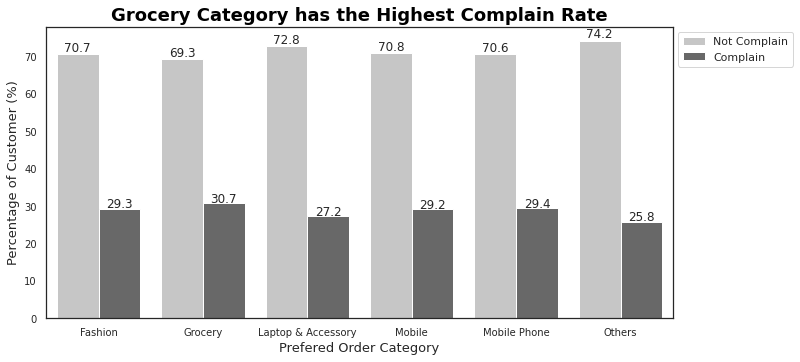

In [ ]:
# Plot Customer count by Category and by Complain 

plt.figure(figsize=(10,5))
ax = sns.barplot(data=group_by_complain3, x='PreferedOrderCat', y='Ratio', hue='Complain', fill=True,palette='Greys')
plt.title('Grocery Category has the Highest Complain Rate', color='black',fontsize=18,fontweight='bold')
plt.legend(loc='upper left',bbox_to_anchor=(1,1),ncol=1);
plt.xlabel('Prefered Order Category',fontsize=13);
plt.ylabel('Percentage of Customer (%)',fontsize=13)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
show_values(ax)

In [ ]:
churn_by_complain = df.groupby(['Churn','Complain']).agg({'CustomerID':'nunique'}).reset_index()
churn_by_complain['Complain'] = group_by_complain['Complain'].replace({1:'Complain',
                                                                0:'Not Complain'})
churn_by_complain

,Churn,Complain,CustomerID
0,0,Not Complain,3586
1,0,Complain,1096
2,1,Not Complain,440
3,1,Complain,508


In [ ]:
df12 = df.groupby(['PreferedOrderCat']).agg({'CustomerID':'nunique'}).reset_index()